In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import os
import jieba

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA = False

In [2]:
SOS_token = 0
EOS_token = 1
PAD_token = 2
UNK_token = 3
MAX_LENGTH = 200

class Lang:
    def __init__(self):
        self.word2index = {'<SOS>': 0, '<EOS>': 1, '<PAD>': 2, '<UNK>': 3}
        self.word2count = {}
        self.index2word = {0: '<SOS>', 1: '<EOS>', 2: '<PAD>', 3: '<UNK>'}
        self.n_words = 4 # Count default tokens

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [3]:
def read_langs(path, mode):
    lang = Lang()
    rm = re.compile(r"\s+", re.MULTILINE)

    # Read text
    raw_text = ""
    if os.path.isdir(path):
        print("loading from path...")
        for filename in os.listdir(path):
            print(path+filename)
            if os.path.isdir(os.path.join(path, filename)): continue
            with open(os.path.join(path, filename), encoding='UTF-8', mode='r') as f:
                temp = rm.sub("", f.read())
                temp = re.sub(r"[『“]", r"「", temp)
                temp = re.sub(r"[』”]", r"」", temp)
                raw_text += temp
    elif os.path.isfile(path):
        print("loading from file...")
        with open(path, encoding='UTF-8', mode='r') as f:
            temp = rm.sub("", f.read())
            temp = re.sub(r"[『“]", r"「", temp)
            temp = re.sub(r"[』”]", r"」", temp)
            raw_text += temp
    else:
        print("Invalid file path. Exiting..." )
        os._exit(1)

    # for i in cut_sentence_new(raw_text):    print(i)
    if mode == 'char':
        word_list = list(raw_text)
    elif mode == 'word':
        word_list = [w for w in jieba.cut(raw_text, cut_all=False)]
    else:
        print('Non-supported mode for training. Exiting...')
        os._exit(1)


    # Map char to int / int to char
    for word in word_list:
        if word not in lang.word2index:
            lang.word2index[word] = lang.n_words
            lang.word2count[word] = 1
            lang.index2word[lang.n_words] = word
            lang.n_words += 1
        else:
            lang.word2count[word] += 1
    # print(self.word2count)
    # Prepare training data, every <seq_length> sequence, predict 1 char after it
    pairs = []
    sentences = cut_sentence_new(raw_text)
    for ind in range(len(sentences)-1):
        pairs.append([sentences[ind], sentences[ind+1]])
    return lang, pairs

In [4]:
def cut_sentence_new(words):
    # words = (words).decode('utf8')
    start = 0
    i = 0
    sents = []
    closure_flag = False
    punt_list = '.!?:;~。！？：；～』”」'
    closure_list = "「“『』”」"
    for word in words:
        if word in closure_list:    closure_flag = not (closure_flag)
        if word in punt_list and token not in punt_list and not (closure_flag):
            # check if next word is punctuation or not
            sents.append(words[start:i + 1])
            start = i + 1
            i += 1
        else:
            i += 1
            token = list(words[start:i + 2]).pop()
            # get next word
    if start < len(words):
        sents.append(words[start:])
    return sents

In [5]:
 def prepare_data(path, mode='word'):
        output_lang, pairs = read_langs(path, mode)
        print("Read {} sentence pairs, total {} words.".format(len(pairs), output_lang.n_words))

        # pairs = self.filter_pairs(pairs)
        # print("Filtered to %d pairs" % len(pairs))
        # for p in pairs:
        #     print(p)
        return output_lang, pairs

output_lang, pairs = prepare_data('C:/Users/han_shih.ASUS/Documents/story/testing/001.txt', 'word')
print(random.choice(pairs))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\HAN_SH~1.ASU\AppData\Local\Temp\jieba.cache


loading from file...


Loading model cost 0.713 seconds.
Prefix dict has been built succesfully.


Read 75 sentence pairs, total 609 words.
['正說著話的當兒，又聽見了敲門聲，接著是大聲的喊叫：', '「小公主啊我的愛，快點兒把門打開！愛你的人已到來，快點兒把門打開！你不會忘記昨天，老椴樹下水潭邊，潭水深深球不見，是你親口許諾言。」']


In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout=0.01, batch_size=1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout, bidirectional=True)

    def forward(self, input_seqs, input_lengths, hidden=None):
#         print(input)
#         embedded = self.embedding(input).view(1, 1, -1)
#         print(embedded.shape)
#         output, hidden = self.gru(embedded, hidden)
#         print(output.shape)

        embedded = self.embedding(input_seqs)
#         print(embedded.size(), input_lengths)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        output, hidden = self.gru(packed, hidden)
        output, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(output)
        output = output[:, :, :self.hidden_size] + output[:, :, self.hidden_size:]  # Sum bidirectional outputs
#         print(output.shape, hidden.shape)
        return output, hidden

    def initHidden(self):
        return torch.zeros(2, self.batch_size, self.hidden_size, device=device)

In [7]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [8]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [9]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        self.hidden_size = hidden_size

        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(this_batch_size, max_len))  # B x S

        if USE_CUDA:  attn_energies = attn_energies.cuda()

        # For each batch of encoder outputs
        for b in range(this_batch_size):
            # Calculate energy for each encoder output
            for i in range(max_len):
                attn_energies[b, i] = self.score(hidden[:, b], encoder_outputs[i, b].unsqueeze(0))

        # Normalize energies to weights in range 0 to 1, resize to 1 x B x S
        # softmax on timestamp dim
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

    def score(self, hidden, encoder_output):
        if self.method == 'dot':
            energy = hidden.mm(encoder_output.t())
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            # print(hidden.size(), energy.size())
            energy = hidden.mm(energy.t())
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = self.v.mm(energy.t())
        else:
            print("undefined scoring strategy!!!")
            return
        return energy

class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(BahdanauAttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        # self.max_length = max_length

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = Attn('concat', hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        # TODO: FIX BATCHING

        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1)  # S=1 x B x N
        word_embedded = self.dropout(word_embedded)

        # Calculate attention weights and apply to encoder outputs
        attn_weights = self.attn(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))  # B x 1 x N (batch matmul)
        context = context.transpose(0, 1)  # 1 x B x N

        # Combine embedded input word and attended context, run through RNN
        rnn_input = torch.cat((word_embedded, context), 2)
        output, hidden = self.gru(rnn_input, last_hidden)

        # Final output layer
        output = output.squeeze(0)  # B x N
        output = F.log_softmax(self.out(torch.cat((output, context), 1)))

        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights


class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        if attn_model != 'none':  # Choose attention model
            self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_seq, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
#         print("decoder forwarding~~~")
#         print(input_seq.shape, last_hidden.shape, encoder_outputs.shape)
        # Get the embedding of the current input word (last output word)
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq)
#         print(batch_size, embedded.shape)
        embedded = self.embedding_dropout(embedded)
#         print(batch_size, embedded.shape)
        embedded = embedded.view(1, batch_size, self.hidden_size)  # S=1 x B x N
#         print(batch_size, embedded.shape)
        # Get current hidden state from input word and last hidden state
        rnn_output, hidden = self.gru(embedded, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs;
        # apply to encoder outputs to get weighted average
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))  # B x S=1 x N

        # Attentional vector using the RNN hidden state and context vector
        # concatenated together (Luong eq. 5)
        rnn_output = rnn_output.squeeze(0)  # S=1 x B x N -> B x N
        context = context.squeeze(1)  # B x S=1 x N -> B x N
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = F.tanh(self.concat(concat_input))

        # Finally predict next token (Luong eq. 6, without softmax)
        output = self.out(concat_output)

        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights
    

In [10]:
# Return a list of indexes, one for each word in the sentence, plus EOS
def indexes_from_sentence(lang, sentence, mode='word'):
    if mode == 'char':
        return [lang.word2index[word] for word in sentence]
    elif mode == 'word':
        return [lang.word2index[word] for word in jieba.cut(sentence, cut_all=False)]
    else:
        print('Non-supported mode for preprocessing! Exiting...')
        os._exit(1)

def tensorFromSentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(output_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [11]:
# Pad a with the PAD symbol
def pad_seq(seq, max_length):
    seq += [PAD_token for i in range(max_length - len(seq))]
    return seq

def random_batch(lang, pairs, batch_size=5, mode='word'):
    input_seqs = []
    target_seqs = []

    # Choose random pairs
    for _ in range(batch_size):
        pair = random.choice(pairs)
        input_seqs.append(indexes_from_sentence(lang, pair[0], mode))
        target_seqs.append(indexes_from_sentence(lang, pair[1], mode))

    # Zip into pairs, sort by length (descending), unzip
    seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs = zip(*seq_pairs)

    # For input and target sequences, get array of lengths and pad with 0s to max length
    input_lengths = [len(s) for s in input_seqs]
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    target_lengths = [len(s) for s in target_seqs]
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]

    # Turn padded arrays into (batch_size x max_len) tensors, transpose into (max_len x batch_size)
    input_var = Variable(torch.LongTensor(input_padded)).transpose(0, 1).to(device)
    target_var = Variable(torch.LongTensor(target_padded)).transpose(0, 1).to(device)

    # print(input_var, input_lengths, target_var, target_lengths)
    return input_var, input_lengths, target_var, target_lengths

In [12]:
import torch
from torch.nn import functional
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def sequence_mask(sequence_length, max_len=None):
    if max_len is None:
        max_len = sequence_length.data.max()
    batch_size = sequence_length.size(0)
    seq_range = torch.range(0, max_len - 1).long()
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand).to(device)
    # if USE_CUDA:
    #     seq_range_expand = seq_range_expand.cuda()
    seq_length_expand = (sequence_length.unsqueeze(1).expand_as(seq_range_expand))
    return seq_range_expand < seq_length_expand


def masked_cross_entropy(logits, target, length):
    length = Variable(torch.LongTensor(length)).to(device)

    """
    Args:
        logits: A Variable containing a FloatTensor of size
            (batch, max_len, num_classes) which contains the
            unnormalized probability for each class.
        target: A Variable containing a LongTensor of size
            (batch, max_len) which contains the index of the true
            class for each corresponding step.
        length: A Variable containing a LongTensor of size (batch,)
            which contains the length of each data in a batch.
    Returns:
        loss: An average loss value masked by the length.
    """

    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1))
    # log_probs_flat: (batch * max_len, num_classes), softmax on timestamp dim
    log_probs_flat = functional.log_softmax(logits_flat, dim=1)
    # target_flat: (batch * max_len, 1)
    target_flat = target.view(-1, 1)
    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())
    # mask: (batch, max_len)
    mask = sequence_mask(sequence_length=length, max_len=target.size(1))
    losses = losses * mask.float()
    loss = losses.sum() / length.float().sum()
    return loss

In [13]:
teacher_forcing_ratio = 0.5


def train(input_batches, input_lengths, target_batches, target_lengths, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

#     input_length = input_tensor.size(0)
#     target_length = target_tensor.size(0)

#     encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

#     for ei in range(input_length):
#         encoder_output, encoder_hidden = encoder(
#             input_tensor[ei], encoder_hidden)
#         encoder_outputs[ei] = encoder_output[0, 0]        
#     decoder_input = torch.tensor([[SOS_token]], device=device)

#     decoder_hidden = encoder_hidden[:decoder.n_layers] #use last hidden state from encoder

    batch_size = len(input_lengths)
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, encoder_hidden)
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size)).to(device)
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder
#     print(encoder_hidden.shape, decoder_hidden.shape)
    max_target_length = max(target_lengths)
    all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size)).to(device)


    use_teacher_forcing = True #if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
#         for di in range(target_length):
#             decoder_output, decoder_hidden, decoder_attention = decoder(
#                 decoder_input, decoder_hidden, encoder_outputs)
#             loss += criterion(decoder_output, target_tensor[di])
#             decoder_input = target_tensor[di]  # Teacher forcing
            
        for t in range(max(target_lengths)):            
            decoder_output, decoder_hidden, decoder_attn = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )

            all_decoder_outputs[t] = decoder_output
            decoder_input = target_batches[t] # Next input is current target

        # Loss calculation and backpropagation
        loss = masked_cross_entropy(
            all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
            target_batches.transpose(0, 1).contiguous(), # -> batch x seq
            target_lengths
        )        

    else:
        # Without teacher forcing: use its own predictions as the next input
#         for di in range(target_length):
#             decoder_output, decoder_hidden, decoder_attention = decoder(
#                 decoder_input, decoder_hidden, encoder_outputs)
#             topv, topi = decoder_output.topk(1)
#             decoder_input = topi.squeeze().detach()  # detach from history as input

#             loss += criterion(decoder_output, target_tensor[di])
#             if decoder_input.item() == EOS_token:
#                 break

    
        for t in range(max(target_lengths)):
#             print(decoder_hidden.shape)
            decoder_output, decoder_hidden, decoder_attn = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            
            all_decoder_outputs[t] = decoder_output
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input                        

        # Loss calculation and backpropagation
        loss = masked_cross_entropy(
            all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
            target_batches.transpose(0, 1).contiguous(), # -> batch x seq
            target_lengths
        )
    
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data.item()

In [14]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [15]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.005, batch_size=10):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
#     training_pairs = [tensorsFromPair(random.choice(pairs))
#                       for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        input_batches, input_lengths, target_batches, target_lengths \
            = random_batch(output_lang, pairs, batch_size=batch_size, mode='word')
#         training_pair = training_pairs[iter - 1]
#         input_tensor = training_pair[0]
#         target_tensor = training_pair[1]

        loss = train(input_batches, input_lengths, target_batches, target_lengths, 
                     encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [16]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [21]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(output_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = torch.zeros(2, 1, encoder.hidden_size, device=device)#encoder.initHidden()
        '''
        
        decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size)).to(device)
        decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder

        max_target_length = max(target_lengths)
        all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size)).to(device)

        use_teacher_forcing = True #if random.random() < teacher_forcing_ratio else False

        for t in range(max(target_lengths)):            
            decoder_output, decoder_hidden, decoder_attn = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )

            all_decoder_outputs[t] = decoder_output
            decoder_input = target_batches[t] # Next input is current target
        '''
        encoder_outputs, encoder_hidden = encoder(input_tensor, [input_length], encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden[:decoder.n_layers]

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):            
#             decoder_output, decoder_hidden, decoder_attention = decoder(
#                 decoder_input, decoder_hidden, encoder_outputs)
#             decoder_attentions[di] = decoder_attention.data
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = Variable(torch.LongTensor([topi])).to(device)#topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [18]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

C:\ProgramData\Miniconda3\lib\site-packages\torch\nn\modules\rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.01 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
C:\ProgramData\Miniconda3\lib\site-packages\torch\nn\modules\rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


3m 0s (- 27m 2s) (50 10%) 5.7542
7m 2s (- 28m 9s) (100 20%) 5.2006
10m 18s (- 24m 3s) (150 30%) 4.9239
13m 14s (- 19m 51s) (200 40%) 4.6287
17m 21s (- 17m 21s) (250 50%) 4.3127
21m 29s (- 14m 19s) (300 60%) 4.0093
25m 10s (- 10m 47s) (350 70%) 3.7505
28m 34s (- 7m 8s) (400 80%) 3.4861
31m 48s (- 3m 32s) (450 90%) 3.2369
35m 32s (- 0m 0s) (500 100%) 3.0382


<Figure size 432x288 with 0 Axes>

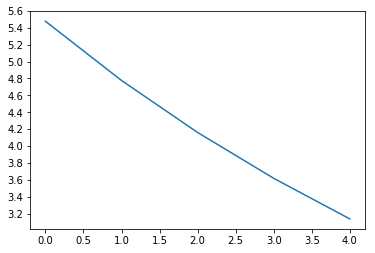

In [19]:
hidden_size = 16
batch_size = 10
encoder1 = EncoderRNN(output_lang.n_words, hidden_size, 1, batch_size=batch_size).to(device)
attn_decoder1 = LuongAttnDecoderRNN('general', hidden_size, output_lang.n_words, 1).to(device)

trainIters(encoder1, attn_decoder1, 500, print_every=50, batch_size=batch_size)

In [22]:
evaluateRandomly(encoder1, attn_decoder1, n=5)

> 小公主兩眼緊緊地盯著金球，可是金球忽地一下子在水潭裡就沒影兒了。
= 因為水潭裡的水很深，看不見底，小公主就哭了起來，她的哭聲越來越大，哭得傷心極了。
< 小 公主 就 她 的 呀 。 」 的 呀 。 」 的 呀 了 。 」 裡 ， 她 的 哭聲 越來 她 的 呀 。 」 隻 越來 她 的 越來 她 的 呀 了 。 」 隻 越來 她 的 越來 她 的 越來 她 的 越來 她 的 呀 了 。 」 隻 越來 她 的 呀 。 」 裡 ， 她 的 哭聲 越來 她 的 越來 她 的 哭聲 越來 她 的 哭聲 越來 她 的 哭聲 越來 她 的 越來 她 的 越來 。 」 的 呀 ， 小 公主 小 公主 就 哭 了 。 」 隻 越來 她 的 越來 她 的 哭聲 傷心極 了 。 」 隻 越來 她 的 哭聲 越來 她 的 哭聲 越來 她 的 越來 她 的 越來 她 的 呀 ， 小 公主 就 很 的 呀 。 」 的 呀 。 」 的 呀 。 」 裡 ， 她 的 哭聲 越來 她 的 越來 哭 。 」 隻 越來 」 隻 越來 她 的 越來 她 的 越來 她 的 哭聲 越來 她 的 哭聲 越來 她 的 越來 她 的 越來 她 的 哭聲 越來 她 的 哭聲 越來 她 的 哭聲

> 馬車來接年輕的王子回他的王國去。
= 忠心耿耿的亨利扶著他的主人和王妃上了車廂，然後自己又站到了車後邊去。
< 對 對 對 對 突然 的 亨利 的 時候 王妃 。 。 。 。 。 。 了 。 。 。 。 。 。 後 ， 聽見 了 車後邊 是 ， 聽見 了 站 。 。 。 。 後 ， 突然 他 的 時候 王妃 了 了 國王 。 。 。 。 」 裡 ， 聽見 啦 。 我 王妃 。 。 。 。 。 。 。 。 」 裡 ， 聽見 了 車後邊 是 。 。 。 。 。 。 。 。 。 。 。 了 。 。 。 。 」 隻 亨利 的 時候 王妃 。 。 。 。 。 。 。 。 。 。 後 ， 「 的 王妃 。 。 。 。 。 。 。 」 的 時候 箍 公主 王妃 。 是 ， 聽見 了 了 國王 。 。 。 。 。 。 」 的 時候 王妃 。 。 。 。 。 。 。 。 」 。 」 隻 美麗 的 亨利 出來 。 」 隻 亨利 的 王國 。 」 的 時候 箍 王子 著 亨利 。 。 。 。 什麼 了 。 。 。 。 。 。 」 的 

In [ ]:
%matplotlib inline
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "「好的，太好了，」")
plt.matshow(attentions.numpy())

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("je sais")

# evaluateAndShowAttention("sans façons !")

# evaluateAndShowAttention("Il n'en est pas question !")

# evaluateAndShowAttention("En aucune manière !")